In [1]:
%matplotlib inline

 # Tutorial 10 - Transfer Learning a CNN
 
 ## Dr. David C. Schedl

This tutorial is geared towards students **experienced in programming** and aims to introduce you to **Computer Vision** techniques.

We will look at tranfer learning with a pre-trained CNN. 
Quote from the CS231n notes:
> In practice, very few people train an entire Convolutional Network
> from scratch (with random initialization), because it is relatively
> rare to have a dataset of sufficient size. Instead, it is common to
> pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
> contains 1.2 million images with 1000 categories), and then use the
> ConvNet either as an initialization or a fixed feature extractor for
> the task of interest.

For training, it is recommended to use a **GPU**. In Google Colab go to the menu and select **Edit** -> **Notebook settings** -> **Hardware accelerator** -> switch to **GPU**.

Useful links:
* [PyTorch documentation](https://pytorch.org/docs/stable/index.html)
* More about transfer learning at [CS231n notes](https://cs231n.github.io/transfer-learning/)

#### Acknowledgements
The code of this tutorial is based on a notebook from a [PyTorch tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) by the author [Sasank Chilamkurthy](https://chsasank.github.io).

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True

## Load Data

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify the 10 classes of CIFAR10, but with a higher resolution and less images.
We have about 100 training images each for each class.
Usually, this is a very small dataset to generalize upon, if trained from scratch. 
Since we are using transfer learning, we should be able to generalize reasonably well.

Note: we use a dataset called [STL-10](https://pytorch.org/vision/stable/generated/torchvision.datasets.STL10.html#torchvision.datasets.STL10), which might take a while to download (~2.5 GB in size).


In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

batch_size = 32  # was 4

image_datasets = {
    "train": torchvision.datasets.STL10(
        root="./data",
        split="train",
        folds=0,
        download=True,
        transform=data_transforms["train"],
    ),
    "val": torchvision.datasets.STL10(
        root="./data",
        split="test",
        folds=0,
        download=True,
        transform=data_transforms["val"],
    ),
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x],
        batch_size=batch_size,
        shuffle=True if x == "train" else False,
        num_workers=2,
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes
print(class_names)
print(dataset_sizes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type != "cuda":
    print("Using CPU! things will be slow! :(")

Files already downloaded and verified
Files already downloaded and verified
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
{'train': 1000, 'val': 8000}


### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



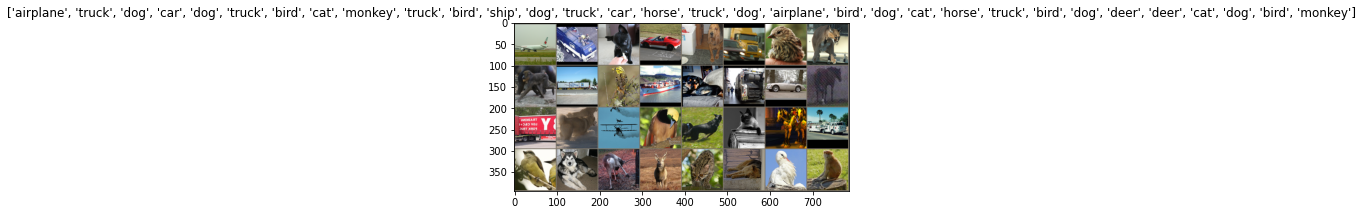

In [4]:
def imshow(inp, title=None, ax=plt):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    if title is not None:
        plt.title(title)
    # plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images. Furthermore, let's also compute the accuracy on the test set.




In [6]:
def visualize_model(model, num_images=6, num_cols=3):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    total, correct = 0, 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):

                if preds[j] == labels.data[j]:
                    correct += 1
                total += 1

                images_so_far += 1
                if images_so_far <= num_images:
                    color = (
                        "green" if preds[j] == labels.data[j] else "red"
                    )  # if correct green, else red
                    ax = plt.subplot(
                        num_images // num_cols,
                        num_cols,
                        images_so_far,
                        xticks=[],
                        yticks=[],
                    )
                    # ax.axis('off')
                    ax.tick_params(color=color, labelcolor=color)
                    ax.set_title(f"pred.: {class_names[preds[j]]}", color=color)
                    imshow(inputs.cpu().data[j], ax=ax)

                    for spine in ax.spines.values():
                        spine.set_edgecolor(color)

        model.train(mode=was_training)
    plt.show()

    print(f"Accuracy: {correct/total*100:.1f}%")
    print(f"Correct: {correct}, Total: {total}")

## Finetuning the convnet

Load a pretrained model and reset final fully connected layer.




In [7]:
model_ft = models.resnet18(weights="DEFAULT")
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to the number of classes.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
# The last layer has random weights, so we need to retrain the network.

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Let's look at the Model in more detail

In [8]:
# PyTorch does not have a summary function (like TensorFlow), so we use torchinfo
!pip install torchinfo
from torchinfo import summary


summary(model_ft, input_size=(1, 3, 224, 224))


[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: C:\Python311\python.exe -m pip install --upgrade pip


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

### Let's see how good our model performs right now (without training)

In [ ]:
visualize_model(model_ft)

### Train and evaluate

It will take a while to train this network. On GPU though, it should be faster.

After training for 25 epochs, we get a val accuracy of >80%.




In [ ]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25
)

In [ ]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the [PyTorch documentation](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).

In [ ]:
model_conv = torchvision.models.resnet18(weights="DEFAULT")
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
# Here the size of each output sample is set to the number of classes.
model_conv.fc = nn.Linear(num_ftrs, len(class_names))
# The last layer has random weights, so one option is to retrain the last layer only.

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

This will take less time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed as well.

After training for 25 epochs, we might get a lower accuracy as before, as we only trained the last layer.
If our new dataset is similar to the original dataset (i.e., ImageNet), then we might expect to get a higher accuracy.




In [ ]:
model_conv = train_model(
    model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25
)

In [ ]:
visualize_model(model_conv)

## Training from scratch

Lets use a model with random weights and train it from scratch. 
This is expected to perform poorly as the dataset is very small and the model is very large.
More epochs (and more data) might help, but it will still run for a long time.




In [ ]:
model_new = models.resnet18(weights=None)
# initialize the weight randomly

num_ftrs = model_new.fc.in_features
# Here the size of each output sample is set to the number of classes.
model_new.fc = nn.Linear(num_ftrs, len(class_names))
# The last layer has random weights, so we need to retrain the network.

model_new = model_new.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_new = optim.SGD(model_new.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_new, step_size=7, gamma=0.1)

In [ ]:
# without training
visualize_model(model_new)

In [ ]:
model_new = train_model(
    model_new, criterion, optimizer_new, exp_lr_scheduler, num_epochs=25
)

In [ ]:
# after training
visualize_model(model_new)